In [1]:
import os, time

In [2]:
# from pprint import pprint as print
print = __builtin__.print

In [3]:
import matplotlib.image as mpimage
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

VISUALIZATION = True

In [4]:
import numpy as np

# Data Representations

## Basic Orientation  

w.r.t displayed digit  

```txt
                ^
  <= (xrot)     | (x-axis)
 (x-to-negy)    |

             =======
                  //
                 //
                //    --> (y-axis)
                ||
                ||   =-· (yrot) (y-to-negz)

          · (paper-out) (z-axis)
```

---

world coordinate

```txt
    ^
    | (z-axis)
    |

 -----===  --> (x-axis)

  /
 /  (y-axis)
/
```

### Visualization

> Note:  
> `(xrot, yrot) = (0, 90)` is exceptional and problematic under this interpretation!  

In [5]:
avail_digits = [ d for d in range(10) ]             # 0, ..., 9
legal_xrots = [ an for an in range(0, 360, 10) ]    # 0, ..., 350
legal_yrots = [ an for an in range(90, -90, -10) ]  # -80, ..., 90

In [6]:
gen_filename = (
    lambda dig, xrot, yrot:
        '字母数字符号大全_pic{}_{}_{}.png'
        .format(*list(map(str, [dig, xrot, yrot])))
)

In [7]:
to_grayscale = (
    lambda img:
        np.sum(img[:, :, :3], axis=2) / 3.0
)

In [8]:
def digit_image_read(digit, xrot, yrot, grayscale=True):
    img = mpimage.imread('../download/'
                         + gen_filename(digit, xrot, yrot))
    img = img[:, :, :3]  # discard alpha channel
    if grayscale:
        img = to_grayscale(img)
    return img

In [9]:
if False:
    for xrot in range(0, 360, 10):
        for yrot in range(90, -90, -10):
            img = digit_image_read(7, xrot, yrot, grayscale=True)
            display.clear_output(wait=True)
            print('xrot:{: 5}'.format(xrot))
            print('yrot:{: 5}'.format(yrot))
            # center_point = (733 // 2, 1200 // 2)
            # print(img[center_point[0]-5:center_point[0]+5, center_point[1]-5:center_point[1]+5])
            # print(img[0, 0])
            plt.imshow(img, cmap='gray'); plt.show()
            time.sleep(1.0)

### Data Types and Formats

Image data is of type `np.ndarray`, with shape of `(733, 1200)` and `4` channels.  

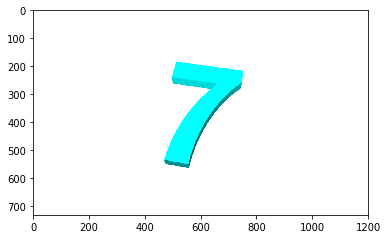

In [10]:
rawimg = mpimage.imread('../download/' + gen_filename(7, 80, 60))
_ = (plt.imshow(rawimg[:, :, :3]), plt.show())  # the assignment op. is for suppressing unnecessary output

**Data Type**

In [11]:
print(type(rawimg))
print(rawimg.shape)

<class 'numpy.ndarray'>
(733, 1200, 4)


**Data Interpreation**  

Using 4-channel PNG image  
- layer \#0 to \#2: R, G, B channels respectively
- layer \#3: alpha channel

layer #0


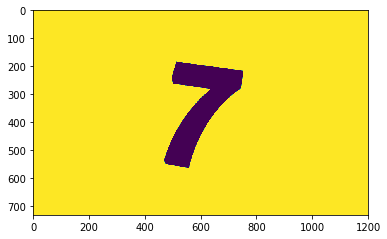

layer #1


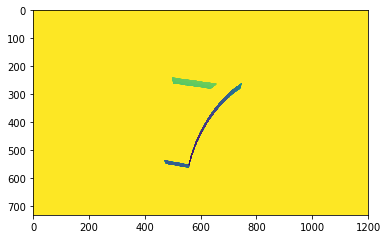

layer #2


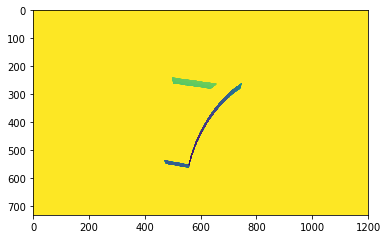

layer #3


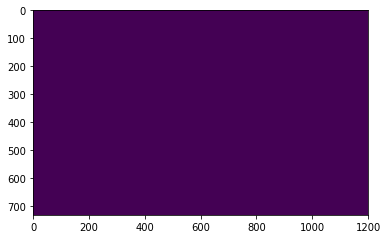

In [12]:
if VISUALIZATION:
    for layer_idx in range(rawimg.shape[-1]):
        print('layer #{}'.format(layer_idx))
        plt.imshow(rawimg[:, :, layer_idx])
        plt.show()

# Model 'N Predict !!!

Using pretrained networks as feature extraction in this example.  

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [14]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

## Build Model, Define Criterion

In [ ]:
from models import DiscriminatorNet
model = DiscriminatorNet(pretrained=True, device=device).to(device=device)
optimizer = optim.Adam(model.parameters(), lr=1e-6)

In [ ]:
which_digit_crit = nn.CrossEntropyLoss()
what_oritent_crit = nn.MSELoss()

## Make Dataset

digit:    5
 xrot:  330
 yrot:   10


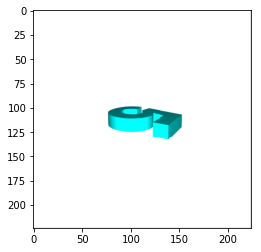

In [ ]:
from datautils import DigitDataset
dataloader = DigitDataset('../download/', grayscale=False, device=device)

if True:
    img, lbl = dataloader.sample()
    display.clear_output()
    print('digit:{: 5}'.format(lbl[0]))
    print(' xrot:{: 5}'.format(lbl[1]))
    print(' yrot:{: 5}'.format(lbl[2]))
    plt.imshow(img); plt.show()

## Build Pipeline

In [ ]:
from itertools import count

In [ ]:
def test(sample_size=10):
    data, labels = dataloader.sample_batch(sample_size)
    data = torch.tensor(data, dtype=torch.float32, device=device)
    labels = torch.tensor(labels, dtype=torch.float32, device=device)
    digit_labels = labels[:, 0].to(dtype=torch.long)
    # print(digit_labels)
    digit_pred_score, _ = model(data)
    digit_pred = torch.argmax(digit_pred_score, dim=1)
    # print(digit_pred)
    acc = (digit_pred == digit_labels).sum().item() / sample_size
    return acc

In [ ]:
def train(
        batch_size=16,
        num_episodes=None):

    logs = {
        'digit_loss': [],
        'orient_loss': [],
        'surrogate_loss': [],
        'test_acc': []
    }

    def train_step():
        torch.cuda.empty_cache()
        # get network prediction
        data, labels = dataloader.sample_batch(batch_size)  # [ ( img_arr, (digit, xrot, yrot) ) ]
        # convert raw data to `torch.tensor`s
        data = torch.tensor(data, dtype=torch.float32, device=device)
        labels = torch.tensor(labels, dtype=torch.float32, device=device)
        # # `digit_labels` should be one-hot encoded
        # digit_labels = torch.zeros(labels.shape[0], 10, dtype=torch.long, device=device)
        # digit_labels = digit_labels.scatter(1, labels[:, 0].unsqueeze(1).to(dtype=torch.long),
        #                                     torch.tensor(1, dtype=torch.long))
        # NO! It is index-encoded!!!
        digit_labels = labels[:, 0].to(dtype=torch.long)
        orient_labels = labels[:, 1:]
        # print('[LOG] data sampled!')
        # make prediction
        digit_pred_score, orient_pred = model(data)
        # print('[LOG] got model prediction!')
        # calculate loss
        # __builtin__.print(digit_pred_score.shape, digit_labels.shape)  # `pprint` throws strange `write` errors
        digit_loss = which_digit_crit(digit_pred_score, digit_labels)
        # __builtin__.print(orient_pred.shape, orient_labels.shape)
        orient_loss = 3.0 * 1e-4 * what_oritent_crit(orient_pred, orient_labels)
        surrogate_loss = digit_loss + 0.0 * orient_loss  # TODO: tune this \tau !!!
        # __builtin__.print('[LOG] got loss:', surrogate_loss)
        # backward prop and update
        optimizer.zero_grad()
        surrogate_loss.backward()
        optimizer.step()
        # print('[LOG] backward-prop completed!')
        # record training progress
        logs['digit_loss'].append(digit_loss)
        logs['orient_loss'].append(orient_loss)
        logs['surrogate_loss'].append(surrogate_loss)

    episode_iter = (count() if not num_episodes else range(num_episodes))

    for ep in episode_iter:
        train_step()
        if ep % 10 == 0:
            logs['test_acc'].append(test(40))
        display.clear_output()
        print('test_acc: (last', logs['test_acc'][-1], ')')
        plt.plot(logs['test_acc']); plt.show()
        print('digit_loss: (last', logs['digit_loss'][-1].item(), ')')
        plt.plot(logs['digit_loss']); plt.show()
        print('orient_loss: (last', logs['orient_loss'][-1].item(), ')')
        plt.plot(logs['orient_loss']); plt.show()
        print('surrogate_loss: (last', logs['surrogate_loss'][-1].item(), ')')
        plt.plot(logs['surrogate_loss']); plt.show()

test_acc: (last 0.15 )


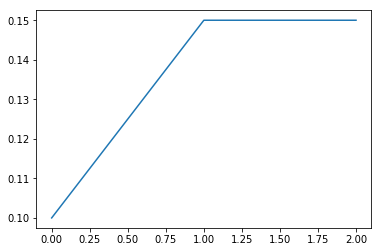

digit_loss: (last 2.276754379272461 )


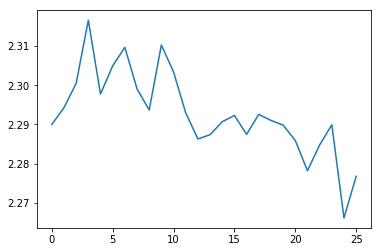

orient_loss: (last 6.259566307067871 )


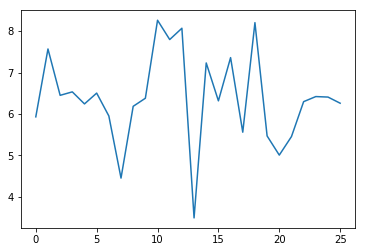

surrogate_loss: (last 2.276754379272461 )


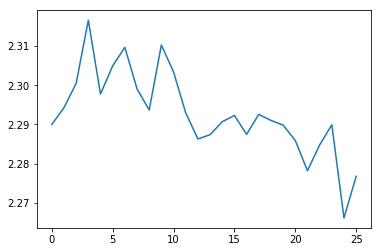

In [ ]:
train(num_episodes=int(1e3))